In [1]:
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

from argparse import Namespace

from sklearn import metrics
from sklearn.model_selection import train_test_split

from datasetPreProcessing import LoadDatasetByName
from models import *
from methods import *

import functools
import numpy as np
import pandas as pd
import torch
import scipy
#import os
import time

import pyod

from pyod.models.base import BaseDetector
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.suod import SUOD
from pyod.models.xgbod import XGBOD

from pyod.models.alad import ALAD
from pyod.models.abod import ABOD
from pyod.models.lof import LOF
from pyod.models.cblof import CBLOF
from pyod.models.cof import COF

from pyod.models.hbos import HBOS
from pyod.models.copod import COPOD
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.loda import LODA

from pyod.models.mcd import MCD
from pyod.models.pca import PCA
from pyod.models.ocsvm import OCSVM
from pyod.models.deep_svdd import DeepSVDD
from pyod.models.kpca import KPCA

# distribution based OD
from pyod.models.kde import KDE

from pyod.models.anogan import AnoGAN

from pyod.models.auto_encoder import AutoEncoder as pyodAE
from pyod.models.vae import VAE as pyodVAE

# supervised OD
from sklearn.ensemble import RandomForestClassifier 
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.linear_model import LogisticRegression


In [2]:
# import data
DATASET = 'ECU_IoHT_data'
#DATASET = 'TON_IoT_data'
#DATASET = 'TON_IoT_full_data'
#DATASET = 'creditcard_data'
#DATASET = 'full_data'
DATASET = 'iiot_data'
#DATASET = 'iiot_data_h'
#DATASET = 'network_data_h'
#DATASET = 'KDD_10'
hardClassify = True

unbalanced_data = True
CONTAMINATION = 0.001
"""___________________Hyper Parameters________________________"""
repetitions = 1

"""___________________________________________________________"""
# Load Dataset
raw_data, anomalous_raw, features, categorical_data_index = LoadDatasetByName(DATASET)
print(raw_data.shape, anomalous_raw.shape)
# Pre-process data
trim_data = True 
filter_corrcoef = True
normalize_data = True
normalization_scheme = "standard_scaling"
remove_noise = False 
noise_threshold = 5
return_dict = {}
SPLIT = [0.9, 0.05, 0.05]
train_data, validation_data, test_data, anomalous_data = preProcessData_OneClass(raw_data, anomalous_raw, trim=trim_data, split=SPLIT, trim_threshold=0.98, normalize=normalize_data, normalization_scheme=normalization_scheme,
            filterLinearDependencies=filter_corrcoef, filter_threshold=0.98, removeNoise=remove_noise, noise_threshold=noise_threshold, return_dict=return_dict, discretize=False, categorical_data_index=categorical_data_index)
print("Train data shape: {}; anomalous data shape: {}".format(train_data.shape, anomalous_data.shape))
# 
specificity_list, recall_list = [], []

(1107448, 43) (87016, 43)
Untrimmed columns:  [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 32, 33, 34, 35, 36, 37, 38, 39]
Train data shape after trim:  (996703, 37)
Train data shape after filter corrcoef:  (996703, 29)
Normalization scheme:  standard_scaling
Train data shape after normalize:  (996703, 29)
Train data shape: (996703, 29); anomalous data shape: (87016, 29)


In [3]:
# list of OD models training on data with both normal data and anomalies
unsupervised_ODs = []
RF = RandomForestClassifier(class_weight='balanced')
HistGB = HistGradientBoostingClassifier(class_weight='balanced')
LR = LogisticRegression(class_weight='balanced')
params_AE = {
    "contamination":CONTAMINATION, "output_activation":'relu', "dropout_rate":0., "l2_regularizer":0e-7, "preprocessing":False,'hidden_neurons':[64, 16, 16, 16, 16, 64],
}

supervised_ODs = [
                    # distribution based algorithms
                    (RF, 'RF'),
                    (HistGB, 'HistGB'),
                    (LR, 'LR')
                    #(ABOD(contamination=0.1, n_neighbors=5), 'ABOD'),   
]
model_list = [
                        #pyodAE(**params_AE),
                        HBOS(contamination=CONTAMINATION),
                        #COPOD(contamination=CONTAMINATION),
                        #LOF(contamination=CONTAMINATION),
                        #KNN(contamination=CONTAMINATION),
                        #
                        #IForest(contamination=CONTAMINATION),
                        
                        # reconstruction/projection based algorithms
                        #PCA(contamination=CONTAMINATION),
                        #DeepSVDD(contamination=CONTAMINATION),
                        #MCD(contamination=CONTAMINATION),
]
# list of OD models training on data with only normal data
semi_supervised_ODs = [
                        (OCSVM(contamination=CONTAMINATION, kernel='linear'), 'OCSVM'),
                        (KPCA(contamination=CONTAMINATION, kernel='linear'), 'KPCA'),
                    ]
distribution_based_ODs = [
                        (HBOS(contamination=CONTAMINATION), 'HBOS'),
                        (COPOD(contamination=CONTAMINATION), 'COPOD'),
                        (MCD(contamination=CONTAMINATION), 'MCD'),
                    ]
density_based_ODs = [
                        (LOF(contamination=CONTAMINATION), 'LOF'),
                        (KNN(contamination=CONTAMINATION, n_neighbors=5, method='median'), 'KNN'),
                        (IForest(contamination=CONTAMINATION), 'IForest'),
                    ]
projection_based_ODs = [
                        (PCA(contamination=CONTAMINATION), 'PCA'),
                        (KPCA(contamination=CONTAMINATION), 'KPCA'),
                        (DeepSVDD(contamination=CONTAMINATION), 'DSVDD'),
                        (OCSVM(contamination=CONTAMINATION, kernel='poly'), 'OCSVM'),
                    ]
# 
best_ODs = [
                        (PCA(contamination=CONTAMINATION), 'PCA'),
                        (MCD(contamination=CONTAMINATION), 'MCD'),
                        (KNN(contamination=CONTAMINATION, n_neighbors=5, method='median'), 'KNN'),
                        #(KPCA(contamination=CONTAMINATION), 'KPCA'),
                        #(DeepSVDD(contamination=CONTAMINATION), 'DSVDD'),
                        #(OCSVM(contamination=CONTAMINATION), 'One-Class-SVM'),
                    ]
# list of OD models training on data with only normal data
all_ODs = [
                        # distribution based algorithms
                        (HBOS(contamination=CONTAMINATION), 'HBOS'),
                        (COPOD(contamination=CONTAMINATION), 'COPOD'),
                        (MCD(contamination=CONTAMINATION), 'MCD'),
                        # proximity/density based algorithms
                        (LOF(contamination=CONTAMINATION), 'LOF'),
                        (KNN(contamination=CONTAMINATION, n_neighbors=5, method='median'), 'KNN'),
                        (IForest(contamination=CONTAMINATION), 'IForest'),
                        # reconstruction/projection based algorithms
                        (PCA(contamination=CONTAMINATION), 'PCA'),
                        (DeepSVDD(contamination=CONTAMINATION), 'DSVDD'),
                        (OCSVM(contamination=CONTAMINATION, kernel='poly'), 'OCSVM'),
                        #(KPCA(contamination=CONTAMINATION, kernel='poly'), 'KPCA'),
                    ]

""" semi_supervised_ODs = [
                        #(pyodAE(contamination=CONTAMINATION,hidden_neurons=[128, 64, 4, 4, 64, 128], output_activation='relu', dropout_rate=0., l2_regularizer=0e-7, preprocessing=False), 'pyodAE'),
                        #(FeatureBagging(base_estimator=pyodAE(), n_estimators=2, contamination=CONTAMINATION, max_features=1.0, combination='max',estimator_params=params_AE), 'FeatureBagging'),
                        #(FeatureBagging(base_estimator=pyodVAE(contamination=0.01), n_estimators=2, contamination=0.1, max_features=1.0, combination='average',estimator_params={'encoder_neurons':[128, 64, 4],'decoder_neurons':[4, 64, 128],}), 'FeatureBagging'),
                        (FeatureBagging(base_estimator=DeepSVDD(contamination=0.05), n_estimators=5, contamination=0.1, max_features=1.0, combination='max'), 'FeatureBagging'),
                        #(SUOD(base_estimators=model_list), 'SUOD'),
                        #(XGBOD(estimator_list=model_list), 'XGBOD'),
                    ] """

" semi_supervised_ODs = [\n                        #(pyodAE(contamination=CONTAMINATION,hidden_neurons=[128, 64, 4, 4, 64, 128], output_activation='relu', dropout_rate=0., l2_regularizer=0e-7, preprocessing=False), 'pyodAE'),\n                        #(FeatureBagging(base_estimator=pyodAE(), n_estimators=2, contamination=CONTAMINATION, max_features=1.0, combination='max',estimator_params=params_AE), 'FeatureBagging'),\n                        #(FeatureBagging(base_estimator=pyodVAE(contamination=0.01), n_estimators=2, contamination=0.1, max_features=1.0, combination='average',estimator_params={'encoder_neurons':[128, 64, 4],'decoder_neurons':[4, 64, 128],}), 'FeatureBagging'),\n                        (FeatureBagging(base_estimator=DeepSVDD(contamination=0.05), n_estimators=5, contamination=0.1, max_features=1.0, combination='max'), 'FeatureBagging'),\n                        #(SUOD(base_estimators=model_list), 'SUOD'),\n                        #(XGBOD(estimator_list=model_list), 'XGBO

In [4]:
pr_dict, roc_dict, mcc_dict = {}, {}, {} # dictionaries of all models' performances to plot
train_time_dict, inference_time_dict = {}, {} # dictionaries of all models' CPU time costs
spec_sens_dict = {}

In [44]:
# pipeline
# train and test data
if unbalanced_data:
    X_train, y_train = train_data, np.zeros(train_data.shape[0])
    X_test = np.concatenate((validation_data, test_data, anomalous_data), axis=0)
    y_test = np.concatenate((np.zeros(validation_data.shape[0]+test_data.shape[0]), np.ones(anomalous_data.shape[0])), axis=0) 
else: # if data is balanced
    X = np.concatenate((train_data, validation_data, test_data, anomalous_data), axis=0)
    Y = np.concatenate((np.zeros(raw_data.shape[0]), np.ones(anomalous_data.shape[0])), axis=0)
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.1, shuffle=True) 

ODs = all_ODs
addition = [(MCD(contamination=CONTAMINATION), 'MCD'),]
ODs = addition

for clf, clf_name in ODs: # loop over all algorithms
    # create prediction (probability) list to compute average upon
    predictions=[]
    
    train_time, inference_time = 0, 0
    for _ in range(repetitions): # r repetitions
        curr_time = time.time() # record train and test CPU time cost
        clf.fit(X_train, y_train) # fit
        train_time += time.time()-curr_time
        
        # test
        curr_time = time.time()
        if hardClassify:
            #y_pred = clf.predict(X_test)
            #y_pred = clf.predict_proba(X_test)
            #y_pred = y_pred[:,-1]
            y_pred = clf.decision_function(X_test)
        else:
            #y_pred = clf.decision_function(X_test)
            print(X_test.shape)
            y_pred = clf.predict_proba(X_test)
            y_pred = y_pred[:,-1]
        #y_pred = np.nan_to_num(y_pred, nan=1e30)
        inference_time += time.time()-curr_time
        predictions.append(y_pred)
    
    # show average time consumption
    train_time, inference_time = train_time/repetitions, inference_time/repetitions
    print("Train time of {}: {:.4f} seconds.".format(clf_name, train_time))
    print("Inference time of {}: {:.4f} seconds.".format(clf_name, inference_time))
    # compute average predictions
    y_pred_average = functools.reduce(lambda a, b: a+b, predictions) / repetitions
    
    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred_average)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred_average)
    #fpr, tpr, thresholds = fpr[1:-1], tpr[1:-1], thresholds[1:-1]
    fpr, tpr, thresholds = fpr, tpr, thresholds
    #thresholds = (thresholds - thresholds.min())/(thresholds.max() - thresholds.min())   # scale thresholds to (0, 1)
    mcc = MCC(specificity=1-fpr, sensitivity=tpr)
    """ if hardClassify:
        specificity, sensitivity = metrics.recall_score(y_true=y_test, y_pred=y_pred_average, pos_label=0), metrics.recall_score(y_true=y_test, y_pred=y_pred_average)
        spec_sens_dict[clf_name] = (specificity, sensitivity) """
        
    pr_dict[clf_name] = (recall, precision)
    roc_dict[clf_name] = (fpr, tpr)
    mcc_dict[clf_name] = (thresholds, mcc)
    train_time_dict[clf_name] = train_time
    inference_time_dict[clf_name] = inference_time



Train time of MCD: 8477.0464 seconds.
Inference time of MCD: 0.1336 seconds.


In [6]:
# get hard classification result
contamination = 0.01
for clf, clf_name in all_ODs:
    clf.set_params(contamination=contamination)
    clf._process_decision_scores() # update thresholds on contamination
    score = clf.predict(X_test)
    precision, recall, f1 = metrics.precision_score(y_test, score), metrics.recall_score(y_test, score), metrics.f1_score(y_test, score)
    print("{}\nPrecision: {:.4f}; Recall: {:.4f}; F-1 score: {:.4f}; at threshold {}".format(clf_name, precision, recall, f1, contamination))

HBOS
Precision: 0.9606; Recall: 0.3010; F-1 score: 0.4583; at threshold 0.01
COPOD
Precision: 0.3831; Recall: 0.0035; F-1 score: 0.0070; at threshold 0.01
LOF
Precision: 0.9859; Recall: 0.9749; F-1 score: 0.9804; at threshold 0.01
KNN
Precision: 0.9874; Recall: 0.9996; F-1 score: 0.9935; at threshold 0.01
IForest
Precision: 0.9117; Recall: 0.1352; F-1 score: 0.2355; at threshold 0.01
PCA
Precision: 0.9377; Recall: 0.1912; F-1 score: 0.3177; at threshold 0.01
6181/6181 [==============================] - 2s 253us/step
DSVDD
Precision: 0.9653; Recall: 0.3608; F-1 score: 0.5253; at threshold 0.01
OCSVM
Precision: 0.9683; Recall: 0.3931; F-1 score: 0.5592; at threshold 0.01


In [7]:
# train supervised ODs
X = np.concatenate((train_data, validation_data, test_data), axis=0)
Y = np.zeros(raw_data.shape[0])
X_train1, X_test1, y_train1, y_test1 = train_test_split(X, Y, train_size=0.9, shuffle=False)

X = anomalous_data
Y = np.ones(anomalous_data.shape[0])
X_train2, X_test2, y_train2, y_test2 = train_test_split(X, Y, train_size=0.5, shuffle=False)

X_train, X_test, y_train, y_test = np.concatenate((X_train1, X_train2), axis=0), np.concatenate((X_test1, X_test2), axis=0), np.concatenate((y_train1, y_train2), axis=0), np.concatenate((y_test1, y_test2), axis=0)

for clf, clf_name in supervised_ODs:
    # create prediction (probability) list to compute average upon
    predictions=[]
    
    train_time, inference_time = 0, 0
    for _ in range(repetitions):
        curr_time = time.time() # record train and test CPU time cost
        clf.fit(X_train, y_train)
        train_time += time.time()-curr_time
        # test
        curr_time = time.time()
        if False:
            #y_pred = clf.predict(X_test)
            #y_pred = clf.predict_proba(X_test)
            #y_pred = y_pred[:,-1]
            y_pred = clf.decision_function(X_test)
        else:
            #y_pred = clf.decision_function(X_test)
            y_pred = clf.predict_proba(X_test)
            y_pred = y_pred[:,-1]
        #y_pred = np.nan_to_num(y_pred, nan=1e30)
        inference_time += time.time()-curr_time
        predictions.append(y_pred)
    
    # show average time consumption
    train_time, inference_time = train_time/repetitions, inference_time/repetitions
    print("Train time of {}: {:.4f} seconds.".format(clf_name, train_time))
    print("Inference time of {}: {:.4f} seconds.".format(clf_name, inference_time))
    # compute average predictions
    y_pred_average = functools.reduce(lambda a, b: a+b, predictions) / repetitions
    
    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred_average)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred_average)
    fpr, tpr, thresholds = fpr, tpr, thresholds
    #mcc = MCC(specificity=1-fpr, sensitivity=tpr)
        
    pr_dict[clf_name] = (recall, precision)
    roc_dict[clf_name] = (fpr, tpr)
    mcc_dict[clf_name] = (thresholds, mcc)
    train_time_dict[clf_name] = train_time
    inference_time_dict[clf_name] = inference_time

(154253, 29)
Train time of RF: 75.8837 seconds.
Inference time of RF: 0.3933 seconds.
(154253, 29)
Train time of HistGB: 6.8049 seconds.
Inference time of HistGB: 0.2186 seconds.
(154253, 29)
Train time of LR: 11.4824 seconds.
Inference time of LR: 0.0200 seconds.


In [107]:
# get hard classification result in supervised models
for clf, clf_name in supervised_ODs:
    if clf_name != 'RF':
        train_loss = clf.decision_function(X_test)
        sorted_train_score = np.sort(train_loss)
        threshold_upper = sorted_train_score[math.floor(len(sorted_train_score)*contamination)]
        score = clf.decision_function(X_test) > threshold_upper
    else:
        score = clf.predict(X_test)
    precision, recall, f1 = metrics.precision_score(y_test, score), metrics.recall_score(y_test, score), metrics.f1_score(y_test, score)
    mcc_score = metrics.matthews_corrcoef(y_test, score)
    print("{}\nPrecision: {:.4f}; Recall: {:.4f}; F-1 score: {:.4f}; MCC: {:.4f} at threshold {}".format(clf_name, precision, recall, f1, mcc_score, contamination))

RF
Precision: 1.0000; Recall: 0.9998; F-1 score: 0.9999; MCC: 0.9998 at threshold 0.01
HistGB
Precision: 0.9747; Recall: 1.0000; F-1 score: 0.9872; MCC: 0.9772 at threshold 0.01
LR
Precision: 0.4440; Recall: 0.9991; F-1 score: 0.6148; MCC: 0.0807 at threshold 0.01


In [96]:
suffix = ''
# import trained AE model and evaluate
from models import AutoEncoder
from models import SVAE

X_train, y_train = train_data, np.zeros(train_data.shape[0])
X_test = np.concatenate((validation_data, test_data, anomalous_data), axis=0)
y_test = np.concatenate((np.zeros(validation_data.shape[0]+test_data.shape[0]), np.ones(anomalous_data.shape[0])), axis=0) 

if True:
    model = AutoEncoder(num_feature=X_test.shape[-1], latent_dim=8, hidden_dim=16, activation="leaky_relu")
    model = VAE(num_feature=X_test.shape[-1], latent_dim=8, hidden_dim=16, activation="leaky_relu", sigma=1e-1)
    model = DAE(num_feature=X_test.shape[-1], latent_dim=8, hidden_dim=16, activation="leaky_relu")
    model.load_state_dict(torch.load('../model/param_'+model.name+'_'+DATASET+suffix))

    # standard for AE is the train average reconstruction loss
    X_temp = torch.tensor(X_train).to(torch.float)
    standard = ((model(X_temp) - X_temp)**2).detach().numpy()
    mu, sig = np.mean(np.sum(standard, axis=-1)), np.std(np.sum(standard, axis=-1), axis=0)
    # infer
    X_temp = torch.tensor(X_test).to(torch.float)
    curr_time = time.time()
    y_pred = model(X_temp)
    # process predictions
    y_pred = ((y_pred - X_temp)**2).detach().numpy()
    y_pred = np.sum(y_pred, axis=-1)
    #y_pred = np.maximum(0, scipy.special.erf((y_pred-mu)/(2**0.5 * sig)))
    #y_pred = 1 / (1 + np.exp(-y_pred + mu))
    inference_time = time.time() - curr_time
    print("Inference time of {}: {:.4f} seconds.".format(model.name, inference_time)) # inference time
    # metrics
    precision, recall, _ = metrics.precision_recall_curve(y_true=y_test, probas_pred=y_pred)
    fpr, tpr, thresholds = metrics.roc_curve(y_true=y_test, y_score=y_pred)
    #fpr, tpr, thresholds = fpr[1:-1], tpr[1:-1], thresholds[1:-1]
    fpr, tpr, thresholds = fpr, tpr, thresholds
    mcc = MCC(specificity=1-fpr, sensitivity=tpr)
    # add metrics to dict
    pr_dict[model.name] = (recall, precision)
    roc_dict[model.name] = (fpr, tpr)
    thresholds = (thresholds - thresholds.min())/(thresholds.max() - thresholds.min())   # scale thresholds to (0, 1)
    mcc_dict[model.name] = (thresholds, mcc)
    # time
    train_time_dict[model.name] = 4012.8189
    inference_time_dict[model.name] = inference_time


Inference time of DAE: 0.2035 seconds.


In [98]:
# get hard classification result in AEs
contamination=0.01

temp = torch.tensor(train_data).to(torch.float)
train_loss = torch.sum((model(temp)-temp)**2, dim=1)
sorted_loss, _ = torch.sort(train_loss)
threshold_upper = sorted_loss[math.floor(len(sorted_loss)*(1-contamination))]
temp = torch.tensor(X_test).to(torch.float)
score = torch.sum((model(temp)-temp)**2, dim=1)
print(score.shape, threshold_upper)
score = score > threshold_upper
score = score.detach().numpy()
precision, recall, f1 = metrics.precision_score(y_test, score), metrics.recall_score(y_test, score), metrics.f1_score(y_test, score)
mcc_score = metrics.matthews_corrcoef(y_test, score)
print("{}\nPrecision: {:.4f}; Recall: {:.4f}; F-1 score: {:.4f}; MCC: {:.4f} at threshold {}".format(model.name, precision, recall, f1, mcc_score, contamination))

torch.Size([197761]) tensor(0.7599, grad_fn=<SelectBackward0>)
DAE
Precision: 0.9869; Recall: 0.9962; F-1 score: 0.9915; MCC: 0.9848 at threshold 0.01


In [89]:
dis = ['HBOS', 'COPOD', 'MCD']
den = ['KNN', 'LOF', 'IForest']
pro = ['PCA', 'DSVDD', 'OCSVM']
all = dis + den + pro + ['AE']
best = ['MCD', 'KNN', 'PCA', 'AE']
supervised = ['RF', 'HistGB', 'LR', 'AE']
aes = ['DAE', 'VAE', 'AE']
#{x:pr_dict[x] for x in dis}
""" train_time_dict.pop('LR')
train_time_dict.pop('RF')
train_time_dict.pop('HistGB')
inference_time_dict.pop('LR')
inference_time_dict.pop('RF')
inference_time_dict.pop('HistGB') """

" train_time_dict.pop('LR')\ntrain_time_dict.pop('RF')\ntrain_time_dict.pop('HistGB')\ninference_time_dict.pop('LR')\ninference_time_dict.pop('RF')\ninference_time_dict.pop('HistGB') "

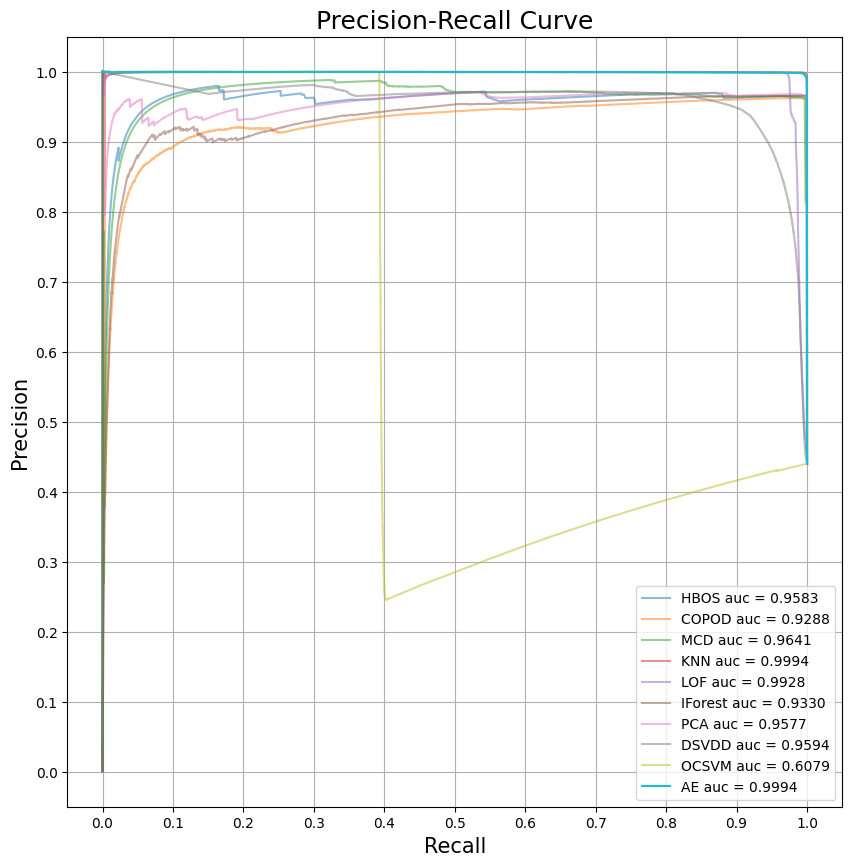

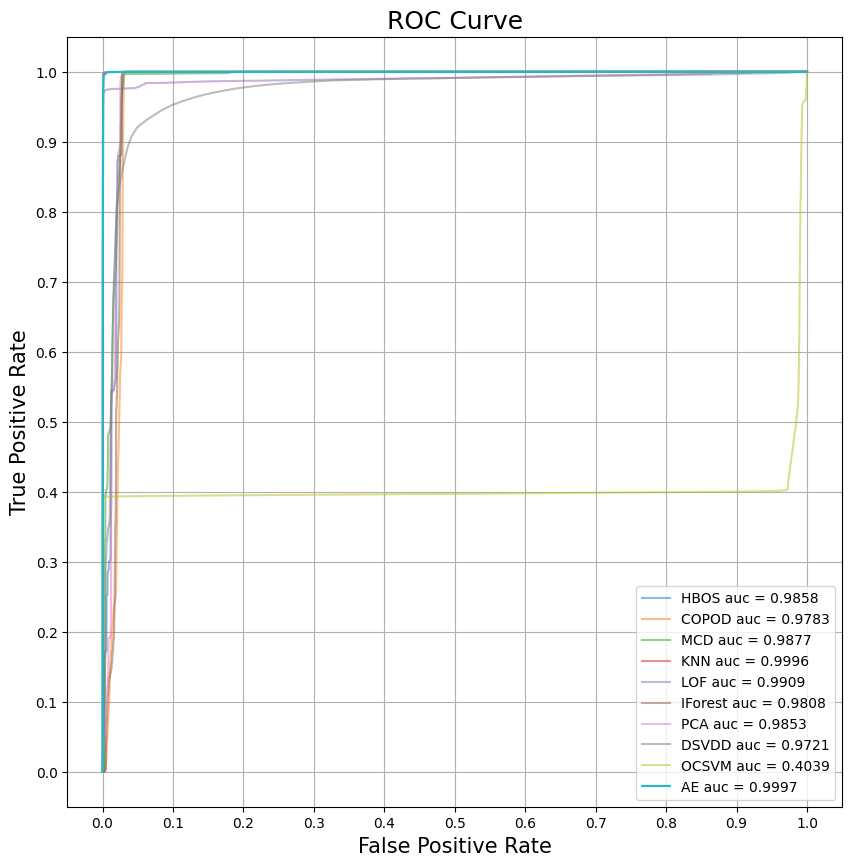

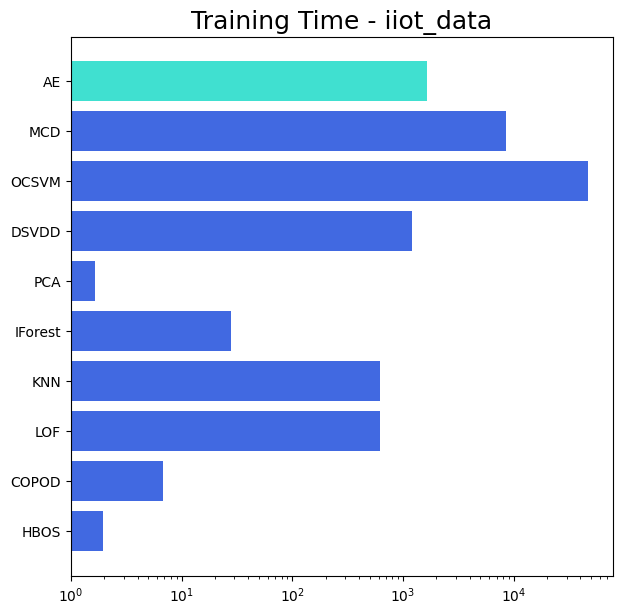

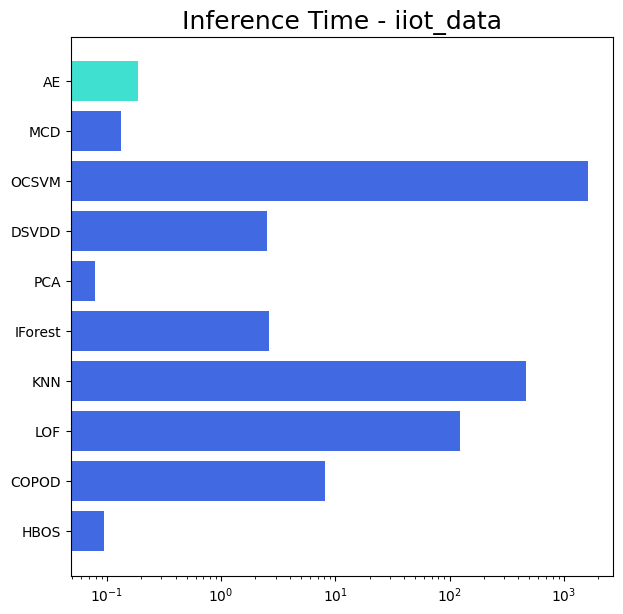

In [92]:
SAVE = True
if DATASET == 'medical_data' or DATASET == 'network_data' or DATASET == 'full_data':
    prefix = 'EHMS '
else:
    prefix = ''
highlight = True

visualize_curve({x:pr_dict[x] for x in all}, x_label="Recall", y_label="Precision", title="Precision-Recall Curve"#+prefix+DATASET
                , save=SAVE, highlight=highlight) 
visualize_curve({x:roc_dict[x] for x in all}, x_label="False Positive Rate", y_label="True Positive Rate", title="ROC Curve"#+prefix+DATASET
                , save=SAVE, highlight=highlight)
                
#visualize_curve(mcc_dict, x_label="Thresholds", y_label="MCC", title="MCC-Threshold Curve - "+prefix+DATASET, save=SAVE) # visualize MCC
visualize_bar(train_time_dict, save=SAVE, title='Training Time - '+prefix+DATASET, highlight=highlight) # visualize training time
visualize_bar(inference_time_dict, save=SAVE, title='Inference Time - '+prefix+DATASET, highlight=highlight) # visualize inference time

In [ ]:
# AE train time
# EHMS-full: 57.1001 seconds. 3000 epochs. 
# medical: 56.3706 seconds. 2000 epochs. 
# TON full: 940.6104 seconds. 1000 epochs.
# iiot: 207.1402 seconds. 100 epochs.
# ECU IoHT: 40.4278 seconds. 1000 epochs.
# KDD_99: 608.4025 seconds. 3000 epochs.
# ToN_IoT_full_data: 917.4541 seconds. 2000 epochs.

KDD-99:

    Train time of HBOS: 0.0647 seconds.
    Inference time of HBOS: 0.1630 seconds.
    Train time of COPOD: 0.6478 seconds.
    Inference time of COPOD: 1.9085 seconds.
    Train time of MCD: 1462.9882 seconds.
    Inference time of MCD: 0.3148 seconds.
    Train time of LOF: 5.6395 seconds.
    Inference time of LOF: 24.5356 seconds.
    Train time of KNN: 4.8981 seconds.
    Inference time of KNN: 154.6989 seconds.
    Train time of IForest: 2.4683 seconds.
    Inference time of IForest: 4.4446 seconds.
    Train time of PCA: 0.1996 seconds.
    Inference time of PCA: 0.2452 seconds.
    
    Train time of DSVDD: 110.1787 seconds.
    Inference time of DSVDD: 4.9240 seconds.
    Train time of One-Class-SVM: 434.2055 seconds.
    Inference time of One-Class-SVM: 716.8229 seconds.

    HBOS
    Precision: 0.9958; Recall: 0.0598; F-1 score: 0.1128; at threshold 0.01
    COPOD
    Precision: 0.9637; Recall: 0.0250; F-1 score: 0.0487; at threshold 0.01
    MCD
    Precision: 0.9991; Recall: 0.2821; F-1 score: 0.4400; at threshold 0.01
    LOF
    Precision: 0.0000; Recall: 0.0000; F-1 score: 0.0000; at threshold 0.01
    KNN
    Precision: 0.9997; Recall: 0.9410; F-1 score: 0.9695; at threshold 0.01
    IForest
    Precision: 0.9992; Recall: 0.2786; F-1 score: 0.4357; at threshold 0.01
    PCA
    Precision: 0.9998; Recall: 0.9574; F-1 score: 0.9781; at threshold 0.01
    12703/12703 [==============================] - 3s 265us/step
    DSVDD
    Precision: 0.9997; Recall: 0.7732; F-1 score: 0.8720; at threshold 0.01
    
    RF
    Precision: 1.0000; Recall: 0.9995; F-1 score: 0.9998; at threshold 0.01
    HistGB
    Precision: 1.0000; Recall: 0.9993; F-1 score: 0.9996; at threshold 0.01
    LR
    Precision: 0.9999; Recall: 0.9856; F-1 score: 0.9927; at threshold 0.01

    
    AE
    Precision: 0.9762; Recall: 0.9994; F-1 score: 0.9877; at threshold 0.01
    DAE
    Precision: 0.9754; Recall: 0.9652; F-1 score: 0.9703; at threshold 0.01
    VAE
    Precision: 0.9762; Recall: 0.9996; F-1 score: 0.9878; at threshold 0.01

TON_IoT:

    HBOS
    Precision: 0.8095; Recall: 0.0004; F-1 score: 0.0008; at threshold 0.01
    COPOD
    Precision: 0.7959; Recall: 0.0063; F-1 score: 0.0124; at threshold 0.01
    MCD
    Precision: 0.9220; Recall: 0.0216; F-1 score: 0.0422; at threshold 0.01
    LOF
    Precision: 0.9948; Recall: 0.3724; F-1 score: 0.5419; at threshold 0.01
    KNN
    Precision: 0.9855; Recall: 0.1245; F-1 score: 0.2210; at threshold 0.01
    IForest
    Precision: 0.8280; Recall: 0.0089; F-1 score: 0.0177; at threshold 0.01
    PCA
    Precision: 0.3779; Recall: 0.0011; F-1 score: 0.0022; at threshold 0.01
    5971/5971 [==============================] - 2s 264us/step
    DSVDD
    Precision: 0.9067; Recall: 0.0190; F-1 score: 0.0372; at threshold 0.01

EHMS_full:

    HBOS
    Precision: 0.8981; Recall: 0.0474; F-1 score: 0.0901; at threshold 0.01
    COPOD
    Precision: 0.9655; Recall: 0.1505; F-1 score: 0.2605; at threshold 0.01
    MCD
    Precision: 0.9851; Recall: 0.4516; F-1 score: 0.6193; at threshold 0.01
    LOF
    Precision: 0.9684; Recall: 0.2991; F-1 score: 0.4571; at threshold 0.01
    KNN
    Precision: 0.9844; Recall: 0.3402; F-1 score: 0.5056; at threshold 0.01
    IForest
    Precision: 0.9813; Recall: 0.4370; F-1 score: 0.6047; at threshold 0.01
    PCA
    Precision: 0.7841; Recall: 0.0337; F-1 score: 0.0647; at threshold 0.01
    106/106 [==============================] - 0s 456us/step
    DSVDD
    Precision: 0.8354; Recall: 0.0323; F-1 score: 0.0621; at threshold 0.01
    
    AE
    Precision: 0.5969; Recall: 0.9511; F-1 score: 0.7335; at threshold 0.01

    RF
    Precision: 0.9969; Recall: 0.3138; F-1 score: 0.4773; at threshold 0.01
    HistGB
    Precision: 0.8773; Recall: 0.4751; F-1 score: 0.6164; at threshold 0.01
    LR
    Precision: 0.6583; Recall: 0.4858; F-1 score: 0.5591; at threshold 0.01

IIoT:

    HBOS
    Precision: 0.9606; Recall: 0.3010; F-1 score: 0.4583; at threshold 0.01
    COPOD
    Precision: 0.3831; Recall: 0.0035; F-1 score: 0.0070; at threshold 0.01
    LOF
    Precision: 0.9859; Recall: 0.9749; F-1 score: 0.9804; at threshold 0.01
    KNN
    Precision: 0.9874; Recall: 0.9996; F-1 score: 0.9935; at threshold 0.01
    IForest
    Precision: 0.9117; Recall: 0.1352; F-1 score: 0.2355; at threshold 0.01
    PCA
    Precision: 0.9377; Recall: 0.1912; F-1 score: 0.3177; at threshold 0.01
    DSVDD
    Precision: 0.9653; Recall: 0.3608; F-1 score: 0.5253; at threshold 0.01
    OCSVM
    Precision: 0.9683; Recall: 0.3931; F-1 score: 0.5592; at threshold 0.01

    AE
    Precision: 0.9872; Recall: 0.9994; F-1 score: 0.9932; at threshold 0.01
    DAE
    Precision: 0.9869; Recall: 0.9962; F-1 score: 0.9915; at threshold 0.01

    RF
    Precision: 1.0000; Recall: 0.9996; F-1 score: 0.9998; at threshold 0.01
    HistGB
    Precision: 0.9999; Recall: 0.9998; F-1 score: 0.9999; at threshold 0.01
    LR
    Precision: 0.9777; Recall: 0.9925; F-1 score: 0.9850; at threshold 0.01



In [ ]:
# save stats
import pickle
if False:
    with open('results/'+DATASET+'/roc_dict.pkl', 'wb') as fp:
        pickle.dump(roc_dict, fp)
        print('dictionary saved successfully to file')
    with open('results/'+DATASET+'/pr_dict.pkl', 'wb') as fp:
        pickle.dump(pr_dict, fp)
        print('dictionary saved successfully to file')
    with open('results/'+DATASET+'/train_time_dict.pkl', 'wb') as fp:
        pickle.dump(train_time_dict, fp)
        print('dictionary saved successfully to file')
    with open('results/'+DATASET+'/inference_time_dict.pkl', 'wb') as fp:
        pickle.dump(inference_time_dict, fp)
        print('dictionary saved successfully to file')


In [ ]:
# load stats
if False:
    with open('results/'+DATASET+'/pr_dict.pkl', 'rb') as fp:
        pr_dict = pickle.load(fp)
        print('Dictionary read successfully.')
    
    with open('results/'+DATASET+'/roc_dict.pkl', 'rb') as fp:
        roc_dict= pickle.load(fp)
        print('Dictionary read successfully.')
        
    with open('results/'+DATASET+'/train_time_dict.pkl', 'rb') as fp:
        train_time_dict = pickle.load(fp)
        print('Dictionary read successfully.')
        
    with open('results/'+DATASET+'/inference_time_dict.pkl', 'rb') as fp:
        inference_time_dict = pickle.load(fp)
        print('Dictionary read successfully.')